In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from optuna.integration import lightgbm as oplgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_squared_error
from optuna.samplers import TPESampler
import japanize_matplotlib

In [2]:
Data = pd.read_csv(r"Dataset.csv",index_col=0,encoding="cp932")

In [3]:
#このセルを実行すると保存したモデルを初期化します
models = {}

# 全期間一斉

In [4]:
# モード選択(Buy or Sell)
mode="Buy"
# 標準化
std_on=False

## データ前処理

- データはBuyとSell分析用に分けたあとそれぞれ上位1%を外れ値として除去
- 説明変数、被説明変数ともに標準化(平均：0，分散：1)

In [5]:
if mode=="Buy":
    DataSetBuy = Data.drop(["ID", "ファンド名",\
                            "解約額", "解約額lag1", "販売手数料", "元本割れ頻度", "元本割れリスク", "シャープレシオ"],axis=1)
    DataSetBuy = DataSetBuy[DataSetBuy["設定額"]<DataSetBuy["設定額"].quantile(0.99)]
    
    # test_Data = DataSetBuy[DataSetBuy["月"].str.contains("2020")].drop(['月'],axis=1)
    DataSetBuy = DataSetBuy.loc[DataSetBuy[DataSetBuy["月"]=="2010/01"].index[0]\
                                :DataSetBuy[DataSetBuy["月"]=="2019/12"].index[-1]].drop(['月'],axis=1)
    
    #訓練データを説明変数データ(X_train)と目的変数データ(y_train)に分割
    X_train = DataSetBuy.drop('設定額', axis=1)
    Y_train = DataSetBuy['設定額']
    
    # X_test = test_Data.drop('設定額', axis=1)
    # Y_test = test_Data['設定額']
    
    if std_on:
        #標準化
        X_train = X_train.apply(lambda x: (x - x.mean()) / x.std())
        Y_train = (Y_train - Y_train.mean()) / Y_train.std()
        # X_test_scale = X_test.apply(lambda x: (x - x.mean()) / x.std())
        # y_test_scale = (Y_test - Y_test.mean()) / Y_test.std()
    
elif mode=="Sell":
    DataSetSell = Data.drop(["ID", "ファンド名",\
                             "設定額", "設定額lag1", "販売手数料", "元本割れ頻度", "元本割れリスク", "シャープレシオ"],axis=1)
    DataSetSell = DataSetSell[(DataSetSell["解約額"]<DataSetSell["解約額"].quantile(0.99))]
    
    # test_Data = DataSetSell[DataSetSell["月"].str.contains("2020")].drop(['月'],axis=1)
    DataSetSell = DataSetSell.loc[DataSetSell[DataSetSell["月"]=="2010/01"].index[0]\
                                  :DataSetSell[DataSetSell["月"]=="2019/12"].index[-1]].drop(['月'],axis=1)
    
    #訓練データを説明変数データ(X_train)と目的変数データ(y_train)に分割
    X_train = DataSetSell.drop('解約額', axis=1)
    Y_train = DataSetSell['解約額']
    
    # X_test = test_Data.drop('解約額', axis=1)
    # Y_test = test_Data['解約額']
    
    if std_on:
        # 標準化
        X_train = X_train.apply(lambda x: (x - x.mean()) / x.std())
        Y_train = (Y_train - Y_train.mean()) / Y_train.std()
        # X_test_scale = X_test.apply(lambda x: (x - x.mean()) / x.std())
        # Y_test_scale = (Y_test - Y_test.mean()) / Y_test.std()

else:
    print("Plese enter mode val 'Buy' or 'Sell'.")

## 学習（Optuna）

- 交差検証は10回行い、ハイパーパラメータを決定

In [6]:
# 訓練データ
lgb_train = lgb.Dataset(X_train, Y_train, free_raw_data = False)

kfold = KFold(n_splits=5,shuffle=True,random_state=0)

# 固定するパラメータ
params = {
    "boosting_type": "gbdt",
    'objective': 'regression',
    'metric': 'rmse',
    'random_state':0,
    "verbosity": -1
}

# Optunaでのパラメータ探索
tuner_cv = oplgb.LightGBMTunerCV(params, lgb_train, verbose_eval=-1,early_stopping_rounds=100,folds=kfold)

tuner_cv.run()

# 最適なパラメータの表示
best_params = tuner_cv.best_params
best_score = tuner_cv.best_score

test_size = 0.3  # 分割比率
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=test_size, random_state=0)

lgb_train = lgb.Dataset(x_train, y_train, free_raw_data = False)
lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train)

# 最適化パラメータで学習器構成
model = lgb.train(best_params, lgb_train, valid_sets=[lgb_test],early_stopping_rounds=100,verbose_eval=-1)
models[mode] = model

[I 2021-10-29 16:13:53,785] A new study created in memory with name: no-name-eb228ca8-f75f-4089-bd1c-c37de6babfb6
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.025766:  14%|#4        | 1/7 [00:19<01:5

/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025724:   5%|5         | 1/20 [00:13<04:20, 13.70s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of 

num_leaves, val_score: 0.025625:  80%|########  | 16/20 [03:12<00:22,  5.62s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025625:  85%|########5 | 17/20 [03:20<00:19,  6.48s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 

/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.025604:  40%|####      | 4/10 [00:16<00:24,  4.08s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of Lig

regularization_factors, val_score: 0.025604:  10%|#         | 2/20 [00:08<01:14,  4.14s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.025604:  15%|#5        | 3/20 [00:12<01:10,  4.12s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine

regularization_factors, val_score: 0.025604:  80%|########  | 16/20 [01:04<00:15,  3.83s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.025604:  85%|########5 | 17/20 [01:10<00:12,  4.31s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engi

min_data_in_leaf, val_score: 0.025604:  80%|########  | 4/5 [00:15<00:03,  3.85s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.025604: 100%|##########| 5/5 [00:17<00:00,  3.52s/it][I 2021-10-29 16:22:36,476] Trial 67 finished with value: 0.025840446044140326 and param

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's rmse: 0.0258222


# 結果（Buy）

In [7]:
Buy_X = x_test
Buy_Y = y_test
Buy_set = pd.concat([Buy_Y,Buy_X],axis=1,sort=False).reset_index(drop=True)
#Buy_set.to_csv()

In [8]:
#Buy all
best_params

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'rmse',
 'random_state': 0,
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 4.102976855396476e-06,
 'lambda_l2': 5.258084461886309e-07,
 'num_leaves': 78,
 'feature_fraction': 0.6,
 'bagging_fraction': 0.8952108754225216,
 'bagging_freq': 6,
 'min_child_samples': 20}

In [9]:
pred_list_Buy = []
y_true = np.array(Y_train)

Y_pred = models["Buy"].predict(X_train)
nrmse_score = np.sqrt(mean_squared_error(y_true, Y_pred))
pred_list_Buy.append(nrmse_score)

Text(0, 0.5, '推定値')

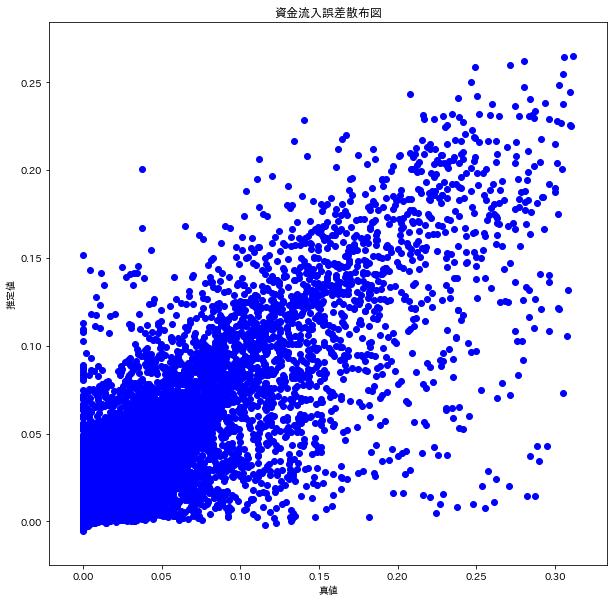

In [10]:
plt.figure(figsize=(10,10))
#plt.rcParams['font.family'] = "MS Gothic"
plt.scatter(Y_train, Y_pred,c='b')
plt.title("資金流入誤差散布図",fontsize=12)
plt.xlabel("真値")
plt.ylabel("推定値")
#plt.savefig()

# 結果（Sell）

In [27]:
Sell_X = x_test
Sell_Y = y_test
Sell_set = pd.concat([Sell_Y,Sell_X],axis=1,sort=False).reset_index(drop=True)
#Sell_set.to_csv()

In [28]:
# Sell
best_params

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'rmse',
 'random_state': 0,
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 0.6980722726703575,
 'lambda_l2': 3.610081038790866e-08,
 'num_leaves': 86,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.9205590241272136,
 'bagging_freq': 6,
 'min_child_samples': 50}

In [29]:
pred_list_Sell = []
y_true = np.array(Y_train)

Y_pred = models["Sell"].predict(X_train)
nrmse_score = np.sqrt(mean_squared_error(y_true, Y_pred))
pred_list_Sell.append(nrmse_score)

Text(0, 0.5, '推定値')

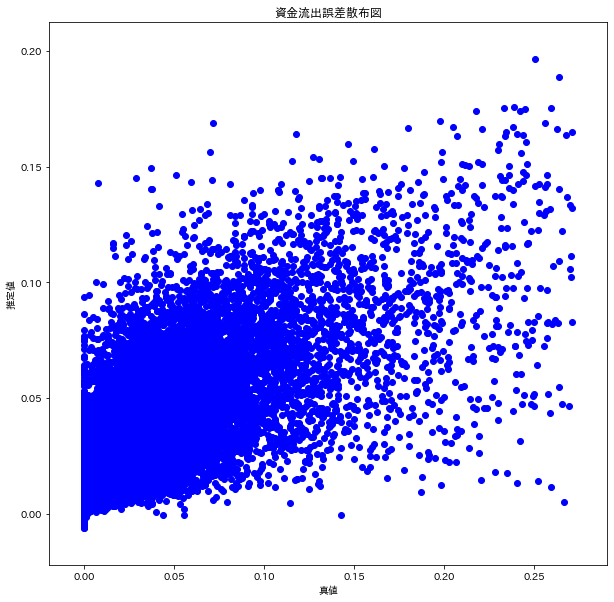

In [30]:
plt.figure(figsize=(10,10))
plt.scatter(Y_train, Y_pred,c='b');
plt.title("資金流出誤差散布図")
plt.xlabel("真値")
plt.ylabel("推定値")
#plt.savefig()

# SHAPley(Buy)

In [11]:
import shap
shap.initjs()

In [12]:
# デフォルト設定
explainer = shap.TreeExplainer(model=models["Buy"])
exData = shap.sample(Buy_X,10000)
shap_v = explainer.shap_values(X=Buy_X)
Buy_shap_v = shap_v

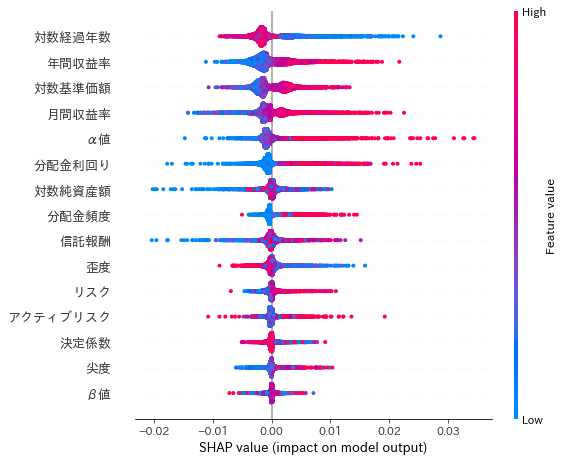

In [13]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Buy_shap_v[:,1:],\
                  features=Buy_X.iloc[:,1:],feature_names=Buy_X.columns[1:],\
                  show=False,max_display=20)
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

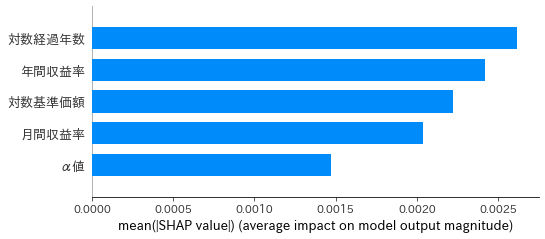

In [14]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Buy_shap_v[:,1:],\
                  features=Buy_X.iloc[:,1:],feature_names=Buy_X.columns[1:],\
                  show=False,plot_type="bar",max_display=5)
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

In [15]:
# SHAP相関図の表示＆保存
def shap_plot(shap_v, X, mode, col_name, save):
    plt.figure(figsize=(15,15))
    shap.dependence_plot(ind=col_name, shap_values=shap_v,features=X,show=False,interaction_index=None)
    if save:
        plt.savefig(r"..\..\Fig\{}_{}.svg".format(mode,col_name)\
                    , dpi=200, bbox_inches="tight", pad_inches=0.1)

<Figure size 1080x1080 with 0 Axes>

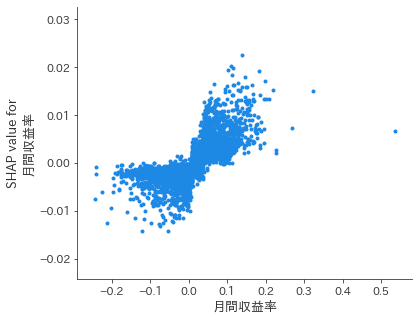

In [16]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '月間収益率', False)# 基準価額の値は対数変換されています

<Figure size 1080x1080 with 0 Axes>

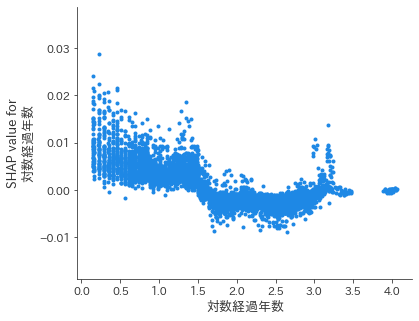

In [17]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '対数経過年数', False)

<Figure size 1080x1080 with 0 Axes>

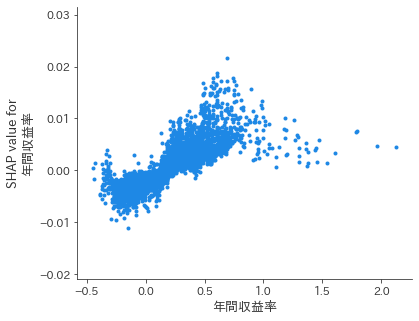

In [18]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '年間収益率', False)

<Figure size 1080x1080 with 0 Axes>

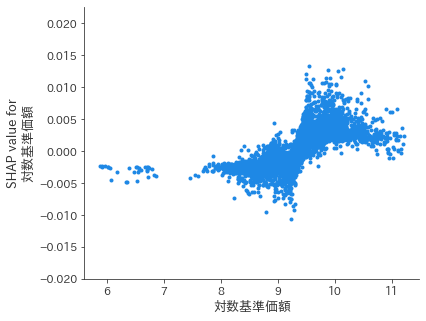

In [19]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '対数基準価額', False)

<Figure size 1080x1080 with 0 Axes>

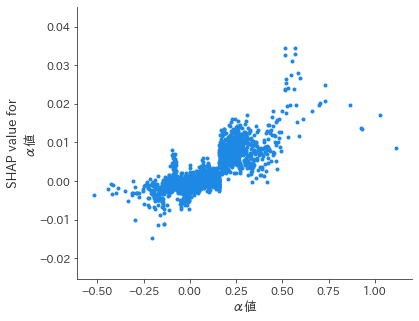

In [20]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', 'α値', False)

<Figure size 1080x1080 with 0 Axes>

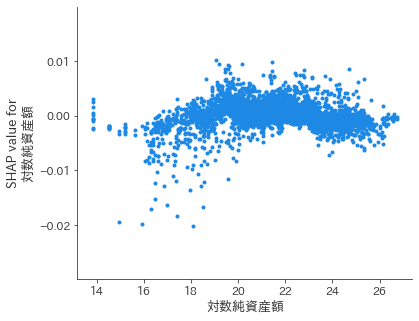

In [21]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '対数純資産額', False)

<Figure size 1080x1080 with 0 Axes>

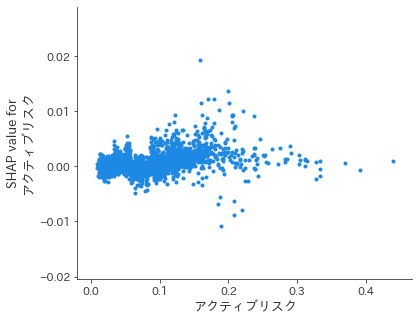

In [22]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', 'アクティブリスク', False)

<Figure size 1080x1080 with 0 Axes>

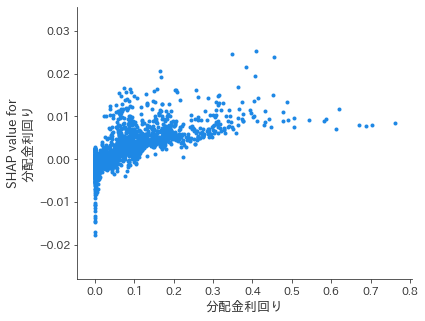

In [23]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '分配金利回り', False)

In [24]:
DF_Buy_shap = pd.DataFrame(Buy_shap_v,columns=Buy_X.columns[:])
DF_Buy_shap.to_csv("Buy_sv.csv")

DF_Buy = pd.DataFrame(Buy_X,columns=Buy_X.columns[:])
DF_Buy.to_csv("Buy.csv")

DF_Buy_shap

,設定額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
0,0.011100,-0.001892,0.004036,-0.003449,0.003664,-0.000763,-0.001320,0.000437,-0.000719,-0.003512,-0.001795,6.144788e-05,-0.001322,-0.000397,0.000938,-0.002942
1,-0.011237,0.000281,-0.001968,0.003258,0.001554,-0.000196,-0.000619,0.001523,-0.000529,-0.002366,-0.000852,-7.240585e-05,-0.000158,-0.000133,0.000754,-0.000329
2,-0.008374,-0.000289,-0.001213,-0.001387,-0.001671,0.000015,-0.000099,0.000061,-0.000370,-0.000958,-0.000936,8.939813e-07,-0.000019,-0.000114,-0.000283,-0.000437
3,-0.010291,-0.000120,-0.002305,-0.000168,-0.001706,0.000056,-0.000079,0.000047,-0.000825,-0.001425,-0.000533,-4.913876e-05,-0.000047,-0.000133,0.000030,-0.000333
4,-0.007647,-0.000201,0.001798,-0.001487,-0.003652,0.000170,0.000283,-0.000109,-0.000708,-0.001449,-0.000978,-8.265844e-05,-0.000327,0.000039,-0.000642,-0.000452
5,-0.011424,0.000119,0.001549,-0.001005,-0.003190,0.000101,0.000308,0.000162,-0.000479,0.002737,-0.000920,4.170111e-06,-0.000038,-0.000042,0.000320,-0.001237
6,-0.011636,0.000017,-0.002585,-0.000372,0.002744,-0.000330,-0.000547,-0.000231,-0.000390,-0.002500,-0.000161,1.040685e-04,0.000007,-0.000066,-0.000052,-0.000600
7,0.002736,-0.000027,0.002609,-0.002085,-0.003607,-0.000051,0.000154,-0.000006,-0.002223,-0.000596,-0.001124,6.197781e-05,-0.000577,0.000130,-0.000358,-0.000465
8,-0.002780,-0.000588,0.000976,-0.000661,-0.003187,0.000690,-0.000026,-0.000184,-0.001321,0.000859,-0.000113,1.070182e-04,-0.000207,-0.000237,-0.000030,-0.000599
9,-0.003689,0.001136,0.002902,0.001209,0.002362,-0.001583,0.000126,-0.000310,-0.001456,0.006556,0.000221,-1.493257e-03,-0.000880,-0.000573,0.000113,-0.000740


## 特定ファンド

In [25]:
target_data_test = pd.read_csv(r"target_data_test.csv",index_col=0)

In [26]:
target_Buy_X = target_data_test.drop(["ID", "ファンド名","設定額","月",\
                            "解約額", "解約額lag1", "販売手数料", "元本割れ頻度", "元本割れリスク", "シャープレシオ"],axis=1)
target_Buy_Y = target_data_test['設定額']
target_Buy_set = pd.concat([target_Buy_Y,target_Buy_X],axis=1,sort=False).reset_index(drop=True)

In [27]:
explainer = shap.TreeExplainer(model=models["Buy"])
exData = shap.sample(target_Buy_X,10000)
shap_v = explainer.shap_values(X=target_Buy_X)
Buy_shap_v = shap_v

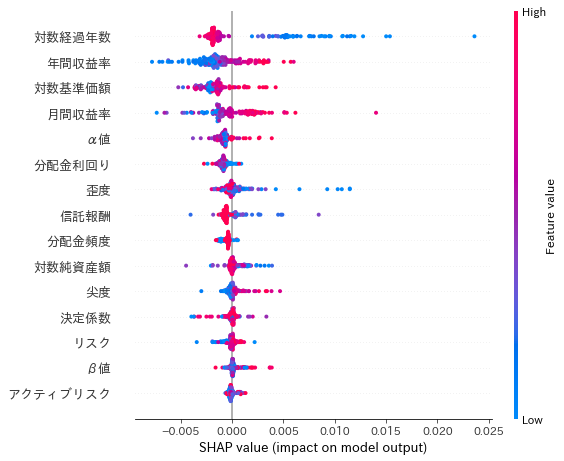

In [29]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Buy_shap_v[:,1:],\
                  features=target_Buy_X.iloc[:,1:],feature_names=target_Buy_X.columns[1:],\
                  show=False,max_display=20)
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

In [30]:
def shap_plot(shap_v, X, mode, col_name, save):
    plt.figure(figsize=(15,15))
    shap.dependence_plot(ind=col_name, shap_values=shap_v,features=X,show=False,interaction_index=None)
    if save:
        plt.savefig(r"..\..\Fig\{}_{}.svg".format(mode,col_name)\
                    , dpi=200, bbox_inches="tight", pad_inches=0.1)

<Figure size 1080x1080 with 0 Axes>

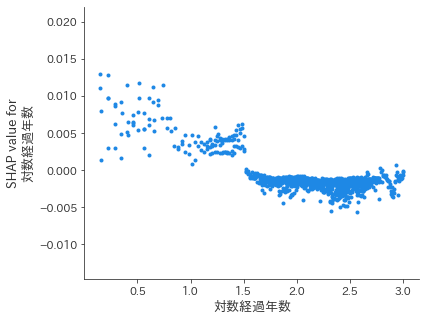

In [63]:
shap_plot(Buy_shap_v, Test_X, 'Buy', '対数経過年数', False)

In [32]:
DF_target_Buy_shap = pd.DataFrame(Buy_shap_v,columns=target_Buy_X.columns[:])
DF_target_Buy_shap.to_csv("target_Buy_sv.csv")

DF_target_Buy = pd.DataFrame(target_Buy_X,columns=target_Buy_X.columns[:])
DF_target_Buy.to_csv("target_Buy.csv")

DF_target_Buy_shap

,設定額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
0,0.082246,0.001572,0.001212,0.014015,-0.002870,0.000825,0.011464,0.004669,0.000681,0.015000,0.000466,0.002246,0.003341,1.311554e-03,0.004898,-0.000266
1,0.081191,0.001446,-0.003239,0.002758,-0.004836,-0.000494,0.010282,0.001094,-0.001917,0.011912,-0.001990,0.001531,0.002010,-4.933977e-04,-0.000375,-0.001576
2,0.077717,-0.002063,-0.003537,-0.001573,-0.007082,-0.000079,0.006561,0.001184,-0.002736,0.011590,-0.000793,-0.001607,0.000597,-5.430852e-04,-0.004042,-0.001161
3,0.009724,0.000352,-0.001547,-0.003935,-0.006262,-0.000004,-0.000323,-0.000025,-0.000705,0.005484,-0.001129,0.000541,-0.002165,-4.972859e-04,-0.000420,-0.001187
4,0.011922,0.000628,-0.003443,-0.001884,-0.006785,0.000309,-0.001528,-0.000329,-0.000159,0.007502,-0.001583,-0.000336,-0.000874,-7.188661e-06,-0.000054,-0.001034
5,-0.010182,0.001536,-0.002782,-0.000933,-0.003115,0.000059,0.001067,-0.000066,-0.000669,0.005329,-0.000859,0.002065,-0.000665,-1.407620e-04,0.001068,-0.000649
6,-0.010419,0.002383,-0.001123,-0.001822,-0.002542,-0.000139,0.000091,-0.000237,-0.000773,0.005044,-0.000846,0.001240,-0.002498,-2.691322e-04,0.000576,-0.000800
7,-0.006887,0.001607,-0.003045,0.002272,-0.004196,0.000152,-0.000584,-0.000532,-0.000623,0.005243,-0.001188,0.001913,-0.000745,-2.625018e-04,0.000308,-0.000606
8,-0.012422,0.003579,-0.000787,0.005326,-0.001816,0.001171,0.001963,0.003400,-0.001069,0.006301,-0.001095,0.003678,0.000142,7.085592e-04,0.002600,-0.000888
9,0.066343,0.000073,-0.001975,-0.003784,-0.006215,0.000211,0.010683,-0.000096,-0.001295,0.011193,-0.003049,-0.000939,0.000394,-2.365163e-04,0.001948,-0.001446


In [34]:
DF_target_Buy

,設定額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
27383,0.120567,18.764270,9.086476,0.041986,-0.098659,0.211965,-1.386886,1.196671,0.011319,0.149836,0.01338,1.23539,0.92961,0.06840,1.353,2
27740,0.202247,18.997294,9.086476,0.000000,-0.097930,0.211989,-1.390177,1.202800,0.011082,0.218200,-0.00628,1.26404,0.95403,0.06274,1.353,2
28097,0.184685,19.218188,9.107643,0.021392,-0.101526,0.211406,-1.387117,1.213392,0.011952,0.284252,0.01449,1.29636,0.96342,0.06233,1.353,2
28458,0.033654,19.153049,9.032051,-0.072806,-0.163310,0.220542,-1.018269,-0.032849,0.011604,0.344270,0.00884,1.28050,0.96952,0.06120,1.353,2
28823,0.036036,19.218188,9.061608,0.029999,-0.128791,0.224303,-1.121816,0.029916,0.000000,0.402722,0.00355,1.27600,0.97025,0.06149,1.353,2
29189,0.004464,19.227157,9.075665,0.014156,-0.118596,0.225191,-1.156536,0.062338,0.000000,0.457945,0.01940,1.28756,0.97529,0.06099,1.353,2
29559,0.000000,19.167369,9.037177,-0.037757,-0.141136,0.226961,-1.027678,-0.250922,0.000000,0.508631,0.02412,1.28453,0.97549,0.06106,1.353,2
29930,0.009174,19.200006,9.105535,0.070749,-0.136377,0.228977,-0.990572,-0.263945,0.000000,0.558441,0.02615,1.28859,0.97573,0.06195,1.353,2
30304,0.000000,19.157845,9.159468,0.055414,0.045775,0.199532,-1.460860,1.811106,0.000000,0.604391,0.03005,1.22924,0.96933,0.05063,1.353,2
30683,0.126374,19.019517,9.174195,0.014836,0.023234,0.197112,-1.418595,1.823631,0.000000,0.649753,-0.00012,1.21417,0.97582,0.04604,1.353,2


# SHAPley(Sell)

In [31]:
import shap
shap.initjs()

In [32]:
# デフォルト設定
explainer = shap.TreeExplainer(model=models["Sell"])
exData = shap.sample(Sell_X,10000)
shap_v = explainer.shap_values(X=Sell_X)
Sell_shap_v = shap_v

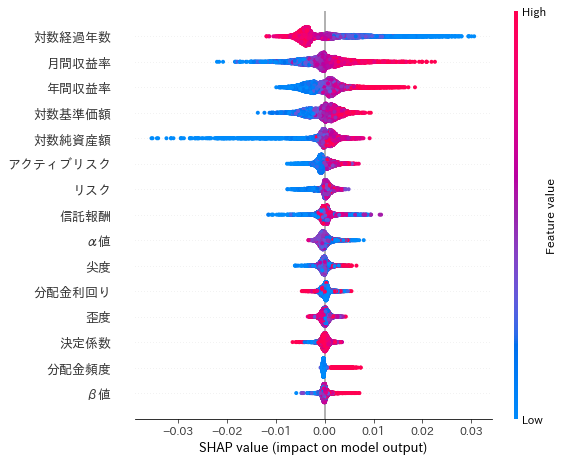

In [33]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Sell_shap_v[:,1:],\
                  features=Sell_X.iloc[:,1:],feature_names=Sell_X.columns[1:],\
                  show=False,max_display=20)
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

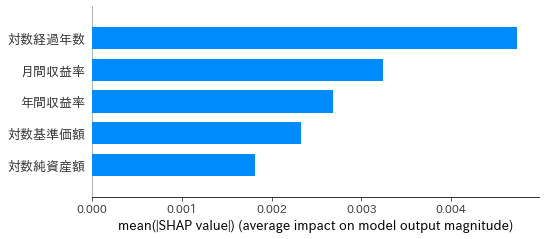

In [34]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Sell_shap_v[:,1:],\
                  features=Sell_X.iloc[:,1:],feature_names=Sell_X.columns[1:],\
                  show=False,max_display=5,plot_type="bar")
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

<Figure size 1080x1080 with 0 Axes>

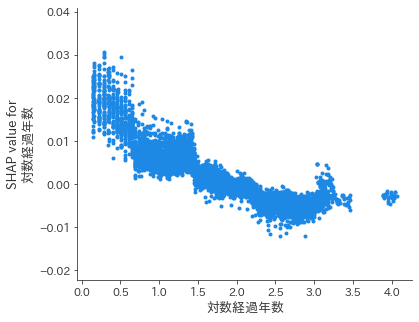

In [36]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '対数経過年数', True)

<Figure size 1080x1080 with 0 Axes>

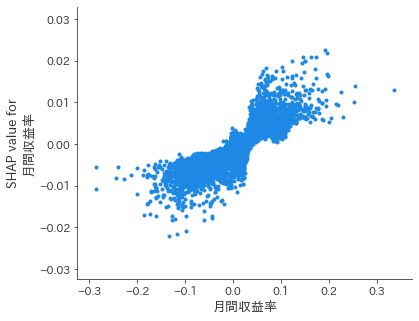

In [37]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '月間収益率', True)

<Figure size 1080x1080 with 0 Axes>

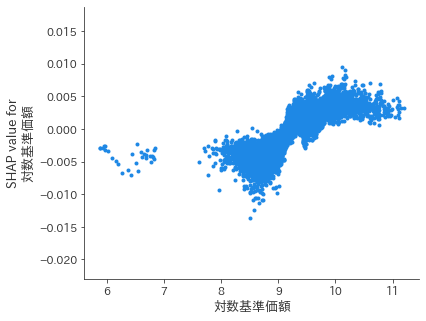

In [38]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '対数基準価額', True)

<Figure size 1080x1080 with 0 Axes>

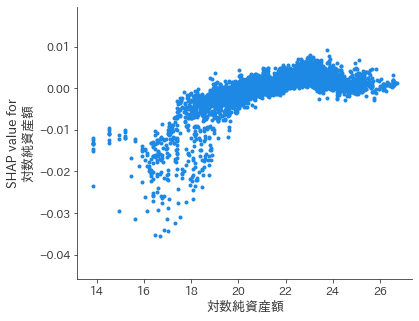

In [39]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '対数純資産額', True)

<Figure size 1080x1080 with 0 Axes>

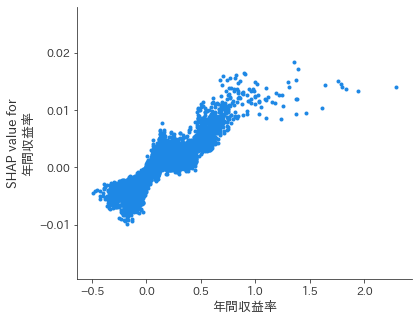

In [40]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '年間収益率', True)

In [41]:
# SHAP相関図の表示＆保存
def shap_plot(shap_v, X, mode, col_name, save):
    plt.figure(figsize=(15,15))
    shap.dependence_plot(ind=col_name, shap_values=shap_v,features=X,show=False,interaction_index=None)
    y_min, y_max = plt.gca().get_ylim()
    plt.gca().set_ylim(y_min, y_max)
    if save:
        plt.savefig(r"..\..\Fig\{}_{}.svg".format(mode,col_name)\
                    , dpi=200, bbox_inches="tight", pad_inches=0.1)

(-0.015, 0.01)

<Figure size 1080x1080 with 0 Axes>

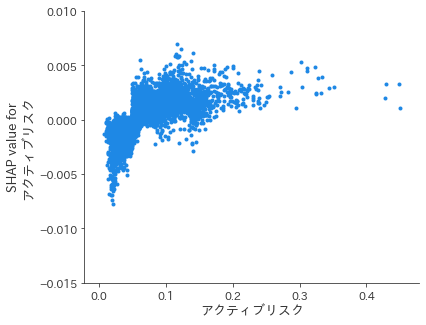

In [42]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', 'アクティブリスク', True)
plt.ylim(-0.015,0.01)


<Figure size 1080x1080 with 0 Axes>

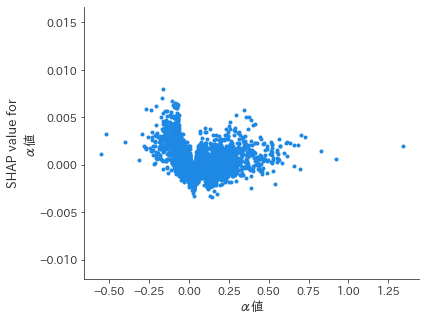

In [43]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', 'α値', True)
#plt.ylim(-0.008,0.017)
#plt.figsize()

<Figure size 1080x1080 with 0 Axes>

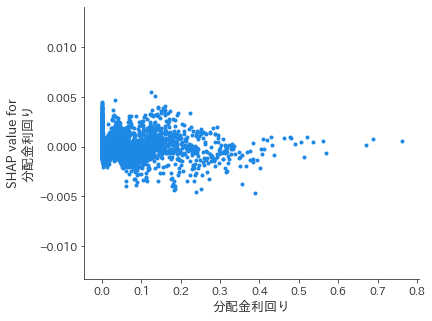

In [44]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '分配金利回り', False)

In [45]:
DF_Sell_shap = pd.DataFrame(Sell_shap_v,columns=Sell_X.columns[:])
DF_Sell_shap.to_csv('Sell_sv.csv')
DF_Sell = pd.DataFrame(Sell_X,columns=Sell_X.columns[:])
DF_Sell.to_csv('Sell.csv')
DF_Sell_shap

,解約額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
0,-0.010041,-0.001284,0.001091,-0.001906,0.002544,-0.003658,-0.001106,-1.469056e-03,0.000334,0.010629,-0.002097,-0.000939,-0.001361,0.000513,0.000087,-0.000340
1,-0.011651,0.000262,0.004788,0.004142,0.002470,-0.000951,-0.000056,-4.513706e-04,0.000325,0.002078,-0.001858,-0.000097,-0.000342,0.001344,-0.000180,-0.000326
2,-0.004178,-0.001358,-0.003379,-0.003977,-0.001825,0.000490,0.001097,1.262863e-03,-0.000803,0.001114,-0.000383,-0.000172,0.000184,-0.000339,0.000567,-0.000171
3,-0.002235,0.000844,-0.003701,-0.000650,-0.003413,-0.000047,-0.001017,7.025856e-07,-0.000398,-0.004067,-0.001028,0.000077,-0.000502,-0.000623,0.000575,-0.000162
4,-0.006401,0.001381,-0.000084,-0.004103,-0.003596,-0.000006,0.000557,6.173466e-04,0.000883,0.008230,-0.000128,-0.000038,0.000194,-0.000308,-0.000293,-0.000292
5,0.012105,0.001692,0.000599,-0.000318,-0.000568,0.001503,0.000057,-9.351976e-04,0.000993,0.001797,0.001315,0.000136,0.000160,-0.000584,0.002096,-0.000014
6,-0.009432,0.000554,-0.004906,-0.002731,0.004469,0.001699,-0.000916,2.113501e-04,0.000357,-0.004699,0.000021,0.000333,-0.000228,0.000484,-0.000310,-0.000214
7,-0.014626,0.000387,-0.000794,-0.004293,-0.005158,-0.000050,-0.000141,3.394687e-04,-0.000476,0.003689,0.001166,-0.000309,-0.000297,-0.000704,0.000346,-0.000162
8,0.033100,0.004432,0.001721,-0.007938,0.001882,0.001551,0.000660,-1.086465e-03,0.001168,0.006269,0.000408,-0.001962,-0.000048,0.001963,0.000068,-0.000392
9,-0.002774,0.000083,0.003592,0.004830,0.001519,-0.000053,0.000248,-5.834966e-04,0.000256,-0.004098,0.000163,-0.000528,-0.000134,-0.002123,-0.001383,-0.000246


In [46]:
DF_Sell

,解約額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
20870,0.008734,19.249233,9.312175,0.007736,0.250085,0.070593,0.285483,1.817902,0.000000,0.607380,0.13551,0.51325,0.27920,0.06959,1.5675,2
12289,0.009388,21.528402,9.828441,0.067058,0.332041,0.109495,0.235047,-0.540831,0.000000,1.778429,0.11612,0.83758,0.67038,0.06522,1.8150,1
2743,0.017649,25.073699,8.780941,-0.058441,-0.054464,0.183961,-0.247430,-0.844796,0.032309,1.734440,0.03714,0.99203,0.92508,0.05037,1.1880,4
1342,0.020190,22.343050,8.337588,0.016298,-0.087110,0.201132,0.412879,0.248777,0.014074,2.391148,0.02354,1.04315,0.97565,0.03244,1.8700,2
29729,0.013936,22.599673,9.160204,-0.035591,-0.112117,0.144908,-0.735174,-0.876323,0.000000,0.733421,-0.00832,0.80504,0.93990,0.04919,1.4190,1
30669,0.045326,24.598293,9.225721,0.005844,0.030441,0.185084,-1.250372,0.747747,0.000000,1.777966,-0.03280,1.12222,0.94342,0.04818,1.5840,2
7871,0.008616,22.124941,8.788898,-0.030871,0.579442,0.226175,0.328181,-1.250123,0.000000,2.877041,-0.03503,1.28384,0.94759,0.07107,1.6830,1
28399,0.000000,22.256255,9.094817,-0.052637,-0.174511,0.160002,-0.798910,0.338649,0.003311,1.386979,-0.04960,0.92782,0.96707,0.03151,1.4630,2
16331,0.100611,23.319863,9.542518,-0.036561,0.119050,0.175506,0.513232,-0.502873,0.000000,0.916839,0.20536,0.77288,0.68982,0.10672,1.9140,1
12194,0.024884,24.919400,9.879809,0.083426,0.265682,0.104414,0.642793,-0.362732,0.000000,2.590747,-0.00651,0.96135,0.96636,0.01959,1.1000,1


## 特定ファンド

In [47]:
target_data_test = pd.read_csv(r"target_data_test.csv",index_col=0)

target_Sell_X = target_data_test.drop(["ID", "ファンド名","解約額","月",\
                            "設定額", "設定額lag1", "販売手数料", "元本割れ頻度", "元本割れリスク", "シャープレシオ"],axis=1)
target_Sell_Y = target_data_test['解約額']
target_Sell_set = pd.concat([target_Sell_Y,target_Sell_X],axis=1,sort=False).reset_index(drop=True)


# デフォルト設定
explainer = shap.TreeExplainer(model=models["Sell"])
exData = shap.sample(target_Sell_X,10000)
target_shap_v = explainer.shap_values(X=target_Sell_X)
target_Sell_shap_v = target_shap_v

DF_target_Sell_shap = pd.DataFrame(target_Sell_shap_v,columns=target_Sell_X.columns[:])
DF_target_Sell_shap.to_csv("target_Sell_sv.csv")

DF_target_Sell = pd.DataFrame(target_Sell_X,columns=target_Sell_X.columns[:])
DF_target_Sell.to_csv("target_Sell.csv")

DF_target_Sell_shap

,解約額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
0,0.018287,-0.018377,-0.000764,0.000397,-0.006365,0.000792,-0.000063,0.000149,-0.000712,0.018315,-0.000589,0.001143,-0.000360,0.002660,-0.000641,0.000074
1,-0.013442,0.001405,-0.001263,-0.002109,-0.007119,0.000805,-0.000274,-0.000799,-0.000264,0.018438,-0.000124,0.001337,0.000074,0.001325,-0.000137,-0.000027
2,-0.015685,0.000307,0.000225,-0.002481,-0.006546,0.000289,-0.000290,-0.000764,-0.000354,0.018786,-0.000878,0.002333,-0.000268,0.000699,-0.000455,-0.000095
3,-0.002421,-0.000499,-0.000661,-0.004200,-0.006243,0.002735,-0.000708,-0.000273,-0.000488,0.018823,-0.000473,0.002637,-0.000319,0.001150,0.000215,0.000064
4,-0.017441,0.000650,-0.000670,-0.001691,-0.006753,0.001315,-0.000825,0.000042,0.000618,0.016068,-0.000340,0.002907,-0.000241,0.001082,-0.000222,0.000097
5,-0.006359,-0.000244,0.000181,-0.001922,-0.006801,0.001724,0.000263,-0.000282,0.000618,0.017761,-0.000514,0.003465,0.000108,0.000912,-0.000214,0.000135
6,-0.002195,-0.000727,-0.000014,-0.003164,-0.006023,0.003322,0.000381,-0.000042,0.000696,0.017667,-0.000670,0.002712,-0.000482,0.001341,0.000183,0.000180
7,0.009972,-0.002595,0.000815,0.009345,-0.006151,0.002856,0.000831,-0.000002,0.001414,0.021741,-0.000856,0.003258,0.000657,0.001630,0.000463,0.000141
8,0.038273,-0.001575,0.001646,0.009950,0.000100,0.002309,0.001544,0.001159,0.002760,0.028960,-0.000862,0.001538,0.001302,0.002012,0.000263,0.000035
9,0.040113,-0.009449,0.000526,-0.006059,0.000609,0.001868,0.002355,0.001541,0.002230,0.023714,-0.000461,0.000407,0.000610,-0.000073,0.000139,-0.000135


In [96]:
DF_target_Sell

,解約額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
16,0.013034,21.523023,8.859789,0.090416,0.084039,0.200673,0.057809,-1.371120,0.000000,1.643376,0.02482,1.05335,0.98957,0.02285,1.650,1
188,0.008625,21.513086,8.856234,-0.003550,0.169082,0.181229,0.080268,-1.108306,0.000000,1.658098,0.02648,1.05778,0.98722,0.02273,1.650,1
361,0.008306,21.496610,8.845633,-0.010544,0.221460,0.169624,0.085807,-0.772970,0.000000,1.674148,0.03106,1.04898,0.98580,0.02169,1.650,1
537,0.031760,21.569134,8.948586,0.108439,0.313257,0.190487,0.078880,-1.197365,0.000000,1.689438,0.03099,1.06475,0.98843,0.02350,1.650,1
714,0.013175,21.578957,8.956222,0.007665,0.212443,0.177459,0.352613,-0.566162,0.000000,1.704997,0.02322,1.06254,0.98643,0.02313,1.650,1
891,0.005769,21.455634,8.835065,-0.114105,-0.007081,0.203644,0.016382,0.379166,0.000000,1.719827,0.01354,1.05797,0.99010,0.02311,1.650,1
1070,0.012768,21.395189,8.777710,-0.055742,-0.085940,0.208684,0.318178,0.146688,0.000000,1.734923,0.01706,1.08319,0.99270,0.02393,1.650,1
1249,0.010644,21.402821,8.789660,0.012022,-0.099808,0.206724,0.388277,0.337997,0.000000,1.749795,0.01495,1.08147,0.99268,0.02353,1.650,1
1428,0.003772,21.341689,8.730044,-0.057874,-0.160309,0.211321,0.626259,0.272501,0.000000,1.763980,0.02175,1.09110,0.99488,0.02320,1.650,1
1607,0.014660,21.370369,8.771680,0.042515,-0.076074,0.212951,0.260693,-0.140254,0.000000,1.778429,0.02201,1.10975,0.99584,0.02511,1.650,1
